# Notebook to forecast quantiles for the DAX

# Imports

In [6]:
import pandas as pd
import numpy as np
import statsmodels as sm
import yfinance as yf
from datetime import datetime
import requests
import json
import sys
import math
import matplotlib.pyplot as plt

from prophet import Prophet

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

import arch
from arch import arch_model

#from darts.models.forecasting.exponential_smoothing import ExponentialSmoothing
#from darts.utils.likelihood_models import GaussianLikelihood
#from darts.timeseries import TimeSeries

pd.set_option('display.max_columns', 500)
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', sys.maxsize)

# Functions

In [7]:
def quantile_loss(y_true, y_pred, quantile):
    
    if y_true > y_pred:
        loss = quantile * (y_true - y_pred)
    else:
        loss = (1 - quantile) * (y_pred - y_true)
    return loss


In [8]:
def energy_eval(energydata, p, q):
    energytraindata = energydata[:-168]
    energytestdata = energydata[-168:]

    enf12 = energytestdata.loc[(energytestdata.index.dayofweek == 4) & (energytestdata.index.hour == 12)]
    enf16 = energytestdata.loc[(energytestdata.index.dayofweek == 4) & (energytestdata.index.hour == 16)]
    enf20 = energytestdata.loc[(energytestdata.index.dayofweek == 4) & (energytestdata.index.hour == 20)]

    ens12 = energytestdata.loc[(energytestdata.index.dayofweek == 5) & (energytestdata.index.hour == 12)]
    ens16 = energytestdata.loc[(energytestdata.index.dayofweek == 5) & (energytestdata.index.hour == 16)]
    ens20 = energytestdata.loc[(energytestdata.index.dayofweek == 5) & (energytestdata.index.hour == 20)]

    energytestdata = pd.concat([enf12, enf16, enf20, ens12, ens16, ens20])

    energyforecast = energy_model(energytraindata, p, q)
    energyforecast = pd.DataFrame(energyforecast, columns = ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"])

    energyevaldata = energytestdata.copy(deep=True)
    energyevaldata["q0.025"] = np.array(energyforecast["q0.025"])
    energyevaldata["q0.25"] = np.array(energyforecast["q0.25"])
    energyevaldata["q0.5"] = np.array(energyforecast["q0.5"])
    energyevaldata["q0.75"] = np.array(energyforecast["q0.75"])
    energyevaldata["q0.975"] = np.array(energyforecast["q0.975"])

    energyevaldata.data = energyevaldata.data / 1000

    #energyevaldata.plot()

    totalloss = 0
    for q in ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"]:
        for i in range(len(energyevaldata)):
            totalloss += quantile_loss(energyevaldata["data"].iloc[i], energyevaldata[q].iloc[i], float(q[1:]))
    print("*********************************")
    print("Quantile Loss: " + str(totalloss))
    print("*********************************")

    return totalloss
    

In [9]:
def dax_eval(daxdata, p, q):
    daxtraindata = daxdata[:-5]
    daxtestdata = daxdata[-5:]

    daxforecast = dax_model(daxtraindata, p, q)
    daxforecast = pd.DataFrame(daxforecast, columns = ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"])
    daxevaldata = daxtestdata.copy(deep=True)

    daxevaldata["q0.025"] = np.array(daxforecast["q0.025"])
    daxevaldata["q0.25"] = np.array(daxforecast["q0.25"])
    daxevaldata["q0.5"] = np.array(daxforecast["q0.5"])
    daxevaldata["q0.75"] = np.array(daxforecast["q0.75"])
    daxevaldata["q0.975"] = np.array(daxforecast["q0.975"])
  
    #daxevaldata.plot()

    totalloss = 0
    for q in ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"]:
        for i in range(len(daxevaldata)):
            totalloss += quantile_loss(daxevaldata["data"].iloc[i], daxevaldata[q].iloc[i], float(q[1:]))
    print("*********************************")
    print("Quantile Loss: " + str(totalloss))
    print("*********************************")

    return totalloss


In [10]:
def compute_return(y, r_type="log", h=1):
    
    # exclude first h observations
    y2 = y[h:]
    # exclude last h observations
    y1 = y[:-h]
    
    if r_type == "log":
        ret = np.concatenate(([np.nan]*h, 100 * (np.log(y2) - np.log(y1))))
    else:
        ret = np.concatenate(([np.nan]*h, 100 * (y2-y1)/y1))
        
    return ret

In [11]:
def create_submission_table():
    forecast_date = [str(datetime.now().date())] * 16
    target = ["DAX"] * 5 + ["energy"] * 6 + ["wind"] * 5
    horizon = ['1 day', '2 day', '5 day', '6 day', '7 day', '36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour', '36 hour', '48 hour', '60 hour', '72 hour', '84 hour']
    
    return pd.DataFrame({"forecast_date": forecast_date, "target": target, "horizon": horizon, "q0.025": [np.nan]*16, "q0.25": [np.nan]*16, "q0.5": [np.nan]*16, "q0.75": [np.nan]*16, "q0.975": [np.nan]*16})

In [12]:
def get_dax_data():
    msft = yf.Ticker("^GDAXI")
    hist = msft.history(period="max")
    data = hist[["Close"]]
    data = data.reset_index().rename(columns={"Date": "date_time"})
    data.set_index("date_time", inplace = True)
    data["data"] = compute_return(data.Close.values)
    data = data.dropna()
    data = data.drop(columns = "Close")
    #data = data.data.values
    
    return data

In [ ]:
# Get energydata from csv
"""def get_energy_data():
    data = pd.read_csv("energy_data.csv", sep=";")
    data = data[data.columns[:3]]
    data = data.rename(columns={"Gesamt (Netzlast)[MWh]": "data"})
    data = data[data["data"] != "-"]
    data["date_time"] = pd.to_datetime(data['Datum'] + ' ' + data['Uhrzeit'], format = '%d.%m.%Y %H:%M')
    data = data.drop(columns = ["Datum", "Uhrzeit"])
    data = data.astype({"data": float})
    data.set_index("date_time", inplace=True)
    data = data.resample("1h", label = "left").sum()
    #data = data.data.values
    
    return data"""

In [13]:
def get_energy_data(): 
    stampsurl = "https://www.smard.de/app/chart_data/410/DE/index_quarterhour.json"
    response = requests.get(stampsurl)
    timestamps = list(response.json()["timestamps"])

    energydata = pd.DataFrame(columns=["date_time", "data"])
    for stamp in timestamps[157:]:
        dataurl = "https://www.smard.de/app/chart_data/410/DE/410_DE_quarterhour_" + str(stamp) + ".json"
        response = requests.get(dataurl)
        rawdata = response.json()["series"]
        for i in range(len(rawdata)):
            rawdata[i][0] = datetime.fromtimestamp(int(str(rawdata[i][0])[:10])).strftime("%Y-%m-%d %H:%M:%S")
        energydata = pd.concat([energydata, pd.DataFrame(rawdata, columns=["date_time", "data"])])
    energydata = energydata.dropna()
    energydata["date_time"] = pd.to_datetime(energydata.date_time)
    energydata.set_index("date_time", inplace=True)
    energydata = energydata.resample("1h", label = "left").sum()

    return energydata

In [14]:
def create_submission_file(submission):
    submission.to_csv(datetime.now().strftime("%Y%m%d") + "_GreyWorm.csv", index = False)
    print("Submission file created")

# Current Models

In [15]:
def dax_model(daxdata, p, q):
    model = arch_model(daxdata, mean='Zero', vol='GARCH', p=p, q=q)
    model_fit = model.fit()
    yhat = model_fit.forecast(horizon=5)

    h1sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.1"].iloc[-1]), size=1000)
    h2sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.2"].iloc[-1]), size=1000)
    h3sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.3"].iloc[-1]), size=1000)
    h4sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.4"].iloc[-1]), size=1000)
    h5sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.5"].iloc[-1]), size=1000)

    quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]

    h1quantiles = np.quantile(h1sample, quantiles)
    h2quantiles = np.quantile(h2sample, quantiles)
    h3quantiles = np.quantile(h3sample, quantiles)
    h4quantiles = np.quantile(h4sample, quantiles)
    h5quantiles = np.quantile(h5sample, quantiles)
    daxquantiles = [h1quantiles, h2quantiles, h3quantiles, h4quantiles, h5quantiles]

    return daxquantiles


In [16]:
def energy_model(energydata, p, q):
    energydata = energydata.loc[energydata.data != 0]
    
    enf12 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 12)]
    enf16 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 16)]
    enf20 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 20)]

    ens12 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 12)]
    ens16 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 16)]
    ens20 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 20)]

    dfs = [enf12, enf16, enf20, ens12, ens16, ens20]
    params = pd.DataFrame(columns = ["h1", "h2", "h3", "h4", "h5", "h6"])
    for i, df in enumerate(dfs):
        model = ARIMA(df.data, order=(p,1,q))
        model_fit = model.fit()
        fc = float(model_fit.forecast(1))
        params[params.columns[i]] = [fc, float(df[-8:].describe().loc["std"])]

    h1sample = np.random.normal(loc=float(params.iloc[0].h1), scale=float(params.iloc[1].h1), size=1000)
    h2sample = np.random.normal(loc=float(params.iloc[0].h2), scale=float(params.iloc[1].h2), size=1000)
    h3sample = np.random.normal(loc=float(params.iloc[0].h3), scale=float(params.iloc[1].h3), size=1000)
    h4sample = np.random.normal(loc=float(params.iloc[0].h4), scale=float(params.iloc[1].h4), size=1000)
    h5sample = np.random.normal(loc=float(params.iloc[0].h5), scale=float(params.iloc[1].h5), size=1000)
    h6sample = np.random.normal(loc=float(params.iloc[0].h6), scale=float(params.iloc[1].h6), size=1000)

    quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]

    h1quantiles = np.quantile(h1sample, quantiles)
    h2quantiles = np.quantile(h2sample, quantiles)
    h3quantiles = np.quantile(h3sample, quantiles)
    h4quantiles = np.quantile(h4sample, quantiles)
    h5quantiles = np.quantile(h5sample, quantiles)
    h6quantiles = np.quantile(h6sample, quantiles)

    energyquantiles = [h1quantiles, h2quantiles, h3quantiles, h4quantiles, h5quantiles, h6quantiles]
    energyquantiles = [q/1000 for q in energyquantiles]

    return energyquantiles

# Modeling

## DAX

### GARCH

In [ ]:
daxdata = get_dax_data()

In [ ]:
model = arch_model(daxdata, mean='Zero', vol='GARCH', p=15, q=15)

In [ ]:
model_fit = model.fit()

In [ ]:
ret2 = daxdata.data**2

In [ ]:
ret2.plot()

In [ ]:
model_fit.plot()

In [ ]:
yhat = model_fit.forecast(horizon=5)
yhat.variance.tail()

In [ ]:
h1sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.1"].iloc[-1]), size=1000)
h2sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.2"].iloc[-1]), size=1000)
h3sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.3"].iloc[-1]), size=1000)
h4sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.4"].iloc[-1]), size=1000)
h5sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.5"].iloc[-1]), size=1000)

quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]

h1quantiles = np.quantile(h1sample, quantiles)
h2quantiles = np.quantile(h2sample, quantiles)
h3quantiles = np.quantile(h3sample, quantiles)
h4quantiles = np.quantile(h4sample, quantiles)
h5quantiles = np.quantile(h5sample, quantiles)
daxquantiles = [h1quantiles, h2quantiles, h3quantiles, h4quantiles, h5quantiles]

## Energy

In [ ]:
energydata = get_energy_data()

In [ ]:
energydata = energydata.loc[energydata.data != 0]

In [ ]:
energydata.plot()

In [ ]:
enf12 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 12)]
enf16 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 16)]
enf20 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 20)]

ens12 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 12)]
ens16 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 16)]
ens20 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 20)]

In [ ]:
ts12 = ens12.copy()
ts12.data = compute_return(ens12.data.values)
ts12 = t12.dropna()
ts12.plot()
plot_pacf(ts12.data, lags=104)


In [ ]:
model = ARIMA(ens12.data, order=(3,1,2))
model_fit = model.fit()
print(model_fit.summary())


In [ ]:
list(model_fit.params)[1:-1]

In [ ]:
arcoefs = [1] + list(model_fit.params)[1:-1][0:3] #0:p
macoefs = [1] + list(model_fit.params)[1:-1][3:3+2] #p:p+q
armadata = ArmaProcess(arcoefs, macoefs).generate_sample(nsample=1000)
pd.DataFrame(armadata).plot()

In [ ]:
pred = model_fit.get_prediction().summary_frame()

In [ ]:
#plot_predict(model_fit)
plt.plot(ens12.index, ens12.data)
plt.plot(pred.iloc[1:].index, pred.iloc[1:]['mean'])
plt.plot(pd.DataFrame(fc).index, pd.DataFrame(fc).predicted_mean)
plt.show()

In [ ]:
fc = model_fit.forecast(1) 

In [ ]:
float(fc)

In [ ]:
float(ens12[-5:].describe().loc["std"])

In [ ]:
dfs = [enf12, enf16, enf20, ens12, ens16, ens20]
params = pd.DataFrame(columns = ["h1", "h2", "h3", "h4", "h5", "h6"])
for i, df in enumerate(dfs):
    model = ARIMA(df.data, order=(3,1,2))
    model_fit = model.fit()
    fc = float(model_fit.forecast(1))
    params[params.columns[i]] = [fc, float(df[-8:].describe().loc["std"])]

In [ ]:
params

In [ ]:
h1sample = np.random.normal(loc=float(params.iloc[0].h1), scale=float(params.iloc[1].h1), size=1000)
h2sample = np.random.normal(loc=float(params.iloc[0].h2), scale=float(params.iloc[1].h2), size=1000)
h3sample = np.random.normal(loc=float(params.iloc[0].h3), scale=float(params.iloc[1].h3), size=1000)
h4sample = np.random.normal(loc=float(params.iloc[0].h4), scale=float(params.iloc[1].h4), size=1000)
h5sample = np.random.normal(loc=float(params.iloc[0].h5), scale=float(params.iloc[1].h5), size=1000)
h6sample = np.random.normal(loc=float(params.iloc[0].h6), scale=float(params.iloc[1].h6), size=1000)

quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]

h1quantiles = np.quantile(h1sample, quantiles)
h2quantiles = np.quantile(h2sample, quantiles)
h3quantiles = np.quantile(h3sample, quantiles)
h4quantiles = np.quantile(h4sample, quantiles)
h5quantiles = np.quantile(h5sample, quantiles)
h6quantiles = np.quantile(h6sample, quantiles)

energyquantiles = [h1quantiles, h2quantiles, h3quantiles, h4quantiles, h5quantiles, h6quantiles]
energyquantiles = [q/1000 for q in energyquantiles]

# Finetuning

## DAX

In [ ]:
params = []
for p in range(1, 16):
    for q in range(16):
        loss = dax_eval(daxdata, p, q)
        params.append([loss, p, q])

In [ ]:
params[[p[0] for p in params].index(min([p[0] for p in params]))]

p = 8 and q = 0 appear to be the best parameters for the DAX GARCH model!

## Energy

In [ ]:
params = []
for p in range(1, 16):
    for q in range(16):
        loss = energy_eval(energydata, p, q)
        params.append([loss, p, q])

In [ ]:
params[[p[0] for p in params].index(min([p[0] for p in params]))]

In [ ]:
enf12 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 12)]
enf16 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 16)]
enf20 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 20)]

ens12 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 12)]
ens16 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 16)]
ens20 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 20)]

/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


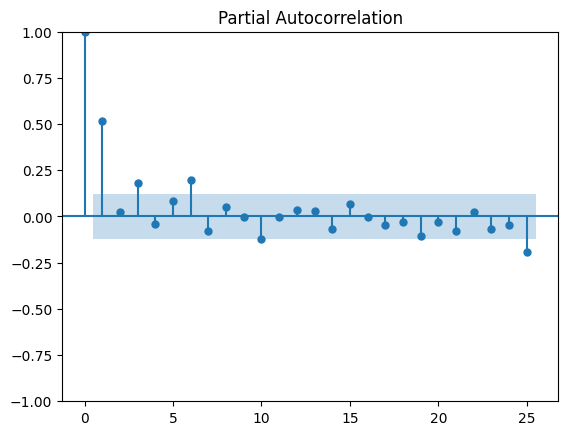

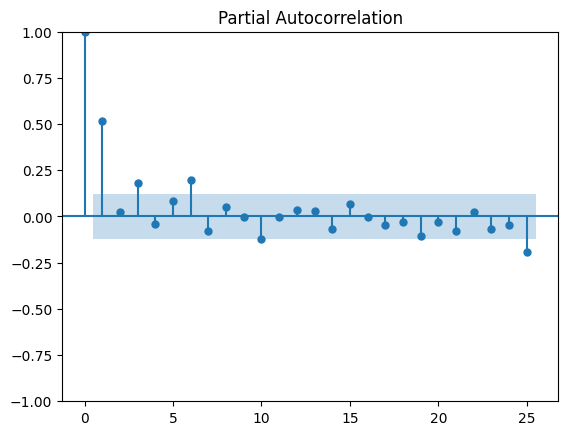

In [55]:
plot_pacf(enf12.data)

p = 9 and q = 9 appear to be the best parameters for Energy ARMA model!

# Submission Creation

In [17]:
submission = create_submission_table()

In [18]:
daxdata = get_dax_data()
energydata = get_energy_data()

In [19]:
daxquantiles = dax_model(daxdata, 8, 0)
energyquantiles = energy_model(energydata, 9, 9)

Iteration:      1,   Func. Count:     11,   Neg. LLF: 21987.052345579705
Iteration:      2,   Func. Count:     25,   Neg. LLF: 938241.0751811876
Iteration:      3,   Func. Count:     36,   Neg. LLF: 212869.26953076536
Iteration:      4,   Func. Count:     47,   Neg. LLF: 3103041.7307996266
Iteration:      5,   Func. Count:     58,   Neg. LLF: 1135931.3395410213
Iteration:      6,   Func. Count:     69,   Neg. LLF: 2352846.1306259623
Iteration:      7,   Func. Count:     80,   Neg. LLF: 5439360.131719231
Iteration:      8,   Func. Count:     91,   Neg. LLF: 151381.36406252274
Iteration:      9,   Func. Count:    102,   Neg. LLF: 118675.54059931201
Iteration:     10,   Func. Count:    114,   Neg. LLF: 32093.021593741127
Iteration:     11,   Func. Count:    125,   Neg. LLF: 18297.262599226837
Iteration:     12,   Func. Count:    138,   Neg. LLF: 17301.787239976205
Iteration:     13,   Func. Count:    149,   Neg. LLF: 14929.26711275553
Iteration:     14,   Func. Count:    160,   Neg. LLF: 

/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/tsa/base/t

In [20]:
for i in range(5):
    submission.loc[i, ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"]] = daxquantiles[i]

In [21]:
for i in range(6):
    submission.loc[5+i, ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"]] = energyquantiles[i]

In [22]:
submission

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2022-11-30,DAX,1 day,-1.649512,-0.511943,0.048289,0.585039,1.794988
1,2022-11-30,DAX,2 day,-1.716118,-0.617634,-0.042450,0.567023,1.659931
2,2022-11-30,DAX,5 day,-1.588044,-0.639968,-0.058170,0.507198,1.536235
3,2022-11-30,DAX,6 day,-2.037259,-0.632306,-0.024385,0.574010,1.810308
4,2022-11-30,DAX,7 day,-1.827064,-0.637587,-0.032211,0.588330,1.821287
5,2022-11-30,energy,36 hour,65.012921,68.100118,69.506895,71.072701,74.067380
6,2022-11-30,energy,40 hour,57.189412,61.465879,63.588049,65.850470,69.939340
7,2022-11-30,energy,44 hour,57.854443,60.308466,61.550533,62.883100,65.341431
8,2022-11-30,energy,60 hour,55.615069,57.697994,58.894911,60.118636,62.436056
9,2022-11-30,energy,64 hour,50.472717,54.558538,56.306684,58.329389,62.026023


In [23]:
create_submission_file(submission)

Submission file created


# Check

In [24]:
! python check.py -p 20221130_GreyWorm.csv

{'path': '20221130_GreyWorm.csv', 'exclude_weather': None}
Loading file... 20221130_GreyWorm.csv
File loaded! Start Checking...
---------------------------
Checking the Columns...
Checking type of columns...
----WARNING: Some elements in q0.025 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.25 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.5 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.75 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.975 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

Checking if the Dates make sense...
Checking targets...
Checking quantiles...
Assume that -- wind -- is your NaN-target. Please DOUBLECHECK if this is correct.
---------------------------
Looks good!


# Testing

## DAX

In [ ]:
dax_eval(daxdata)

In [ ]:
daxdata = get_dax_data()
daxtraindata = daxdata[:-5]
daxtestdata = daxdata[-5:]

In [ ]:
daxtestdata.tail(10)

In [ ]:
daxforecast = dax_model(daxtraindata)

In [ ]:
daxforecast = pd.DataFrame(daxforecast, columns = ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"])

In [ ]:
daxforecast["q0.025"]

In [ ]:
daxtestdata

In [ ]:
daxevaldata = daxtestdata.copy(deep=True)
daxevaldata["q0.025"] = np.array(daxforecast["q0.025"])
daxevaldata["q0.25"] = np.array(daxforecast["q0.25"])
daxevaldata["q0.5"] = np.array(daxforecast["q0.5"])
daxevaldata["q0.75"] = np.array(daxforecast["q0.75"])
daxevaldata["q0.975"] = np.array(daxforecast["q0.975"])

In [ ]:
daxevaldata.plot()

In [ ]:
totalloss = 0
for q in ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"]:
    for i in range(len(daxevaldata)):
        totalloss += quantile_loss(daxevaldata["data"].iloc[i], daxevaldata[q].iloc[i], float(q[1:]))
totalloss

## Energy

In [ ]:
energy_eval(energydata)

In [ ]:
#energydata = get_energy_data()
energytraindata = energydata[:-168]
energytestdata = energydata[-168:]

In [ ]:
enf12 = energytestdata.loc[(energytestdata.index.dayofweek == 4) & (energytestdata.index.hour == 12)]
enf16 = energytestdata.loc[(energytestdata.index.dayofweek == 4) & (energytestdata.index.hour == 16)]
enf20 = energytestdata.loc[(energytestdata.index.dayofweek == 4) & (energytestdata.index.hour == 20)]

ens12 = energytestdata.loc[(energytestdata.index.dayofweek == 5) & (energytestdata.index.hour == 12)]
ens16 = energytestdata.loc[(energytestdata.index.dayofweek == 5) & (energytestdata.index.hour == 16)]
ens20 = energytestdata.loc[(energytestdata.index.dayofweek == 5) & (energytestdata.index.hour == 20)]

energytestdata = pd.concat([enf12, enf16, enf20, ens12, ens16, ens20])

In [ ]:
energyforecast = energy_model(energytraindata)

In [ ]:
energyforecast = pd.DataFrame(energyforecast, columns = ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"])

In [ ]:
energyevaldata = energytestdata.copy(deep=True)
energyevaldata["q0.025"] = np.array(energyforecast["q0.025"])
energyevaldata["q0.25"] = np.array(energyforecast["q0.25"])
energyevaldata["q0.5"] = np.array(energyforecast["q0.5"])
energyevaldata["q0.75"] = np.array(energyforecast["q0.75"])
energyevaldata["q0.975"] = np.array(energyforecast["q0.975"])

In [ ]:
energyevaldata.data = energyevaldata.data / 1000

In [ ]:
energyevaldata

In [ ]:
energyevaldata.plot()

In [ ]:
totalloss = 0
for q in ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"]:
    for i in range(len(energyevaldata)):
        totalloss += quantile_loss(energyevaldata["data"].iloc[i], energyevaldata[q].iloc[i], float(q[1:]))
totalloss